In [1]:
!pip install --upgrade -q git+https://github.com/keras-team/keras-cv

In [2]:
!pip install transformers

In [3]:
import pandas as pd
import numpy as np
from transformers import DistilBertTokenizer, DistilBertModel
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, concatenate
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [4]:
DATA_PATH = "/kaggle/input/dm-dataset/data mining project"
data = pd.read_csv(DATA_PATH+"/hatefulmemes.csv")
data.head()

,id,img,label,text
0,42953,img/42953.png,0,its their character not their color that matters
1,23058,img/23058.png,0,don't be afraid to love again everyone is not ...
2,13894,img/13894.png,0,putting bows on your pet
3,37408,img/37408.png,0,i love everything and everybody! except for sq...
4,82403,img/82403.png,0,"everybody loves chocolate chip cookies, even h..."


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8500 entries, 0 to 8499
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      8500 non-null   int64 
 1   img     8500 non-null   object
 2   label   8500 non-null   int64 
 3   text    8500 non-null   object
dtypes: int64(2), object(2)
memory usage: 265.8+ KB


In [6]:
!pip install nltk

In [7]:
import nltk


nltk.download('punkt')
nltk.download('stopwords')



[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [8]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string

def clean_text_with_nltk(text):
    # Convert text to lowercase
    text = text.lower()
    
    # Tokenize the text into words
    words = word_tokenize(text)
    
    # Remove punctuation and numbers
    words = [word for word in words if word.isalpha()]
    
    # Remove stop words
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]
    
    # Join the cleaned words back into a string
    cleaned_text = ' '.join(words)
    
    return cleaned_text

In [9]:
data["clean_text"] = data["text"].apply(clean_text_with_nltk)

In [10]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import optimizers
import keras_cv
import numpy as np
from keras_cv import bounding_box
import os
import resource
from keras_cv import visualization
import tqdm

Using TensorFlow backend


In [11]:
# for object detection first lets try the yolov8 model backbone to extract image features with pretrained on coco dataset
backbone = keras_cv.models.YOLOV8Backbone.from_preset(
        "yolo_v8_xl_backbone_coco"
)

124353200/124353200 [==============================] - 1s 0us/step


In [12]:
from transformers import BertTokenizer, BertModel
model_name = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [13]:
X_train, X_test = train_test_split(data, test_size=0.2, random_state=42, shuffle=True)

In [14]:
from tqdm import tqdm_notebook
inference_resizing = keras_cv.layers.Resizing(
  640, 640, pad_to_aspect_ratio=True, bounding_box_format="xywh"
)

feature_extractor_1 = tf.keras.models.Model(inputs=backbone.input, outputs=backbone.get_layer('stack4_spp_fast_output').output)
flatten_layer = keras.layers.Flatten()(feature_extractor_1.output)
feature_extractor_2 = keras.models.Model(inputs=feature_extractor_1.input, outputs=flatten_layer)
max_length = 20

def text_feature_extraction(t):
  
  preprocessed_text = []
  preprocessed_image = []
  labels = []
  for i in tqdm.notebook.tqdm(t.iterrows(), total=len(t)):
    try:
        image = keras.utils.load_img("/kaggle/input/dm-dataset/data mining project"+f'''/{i[1]["img"]}''')
        image = np.array(image)
        image_batch = inference_resizing([image])
        preprocessed_image.append(feature_extractor_2.predict(image_batch, verbose=0))
        text_tokens = tokenizer(i[1]["clean_text"], padding=True, truncation=True, return_tensors="pt", max_length=max_length)
        preprocessed_text.append(np.reshape(model(**text_tokens)['last_hidden_state'][:, 0, :].detach().numpy(), (768)))
        labels.append(i[1]["label"])
    except Exception as e:
        pass
  return preprocessed_text, preprocessed_image, labels
train_text, train_image, train_label = text_feature_extraction(X_train)
test_text, test_image, test_label = text_feature_extraction(X_test)

  0%|          | 0/6800 [00:00<?, ?it/s]

  0%|          | 0/1700 [00:00<?, ?it/s]

In [15]:
train_text = np.asarray(train_text)
train_image = np.reshape(np.asarray(train_image), (len(train_text),256000))
train_label = np.asarray(train_label)
test_text = np.asarray(test_text)
test_image = np.reshape(np.asarray(test_image), (len(test_text),256000))
test_label = np.asarray(test_label)

In [16]:
print(train_text.shape)
print(train_image.shape)
print(train_label.shape)
print(test_text.shape)
print(test_image.shape)
print(test_label.shape)

(3452, 768)
(3452, 256000)
(3452,)
(826, 768)
(826, 256000)
(826,)


In [17]:
from tensorflow import keras
from tensorflow.keras.layers import Input, Concatenate, Dense

# Define your text input layer with shape (768,)
text_input = Input(shape=(768,))

# Define your image input layer with shape (256000,)
image_input = Input(shape=(256000,))

# Define a neural network for processing the image input
image_network = keras.models.Sequential([
    keras.layers.Dense(768, activation='relu', input_shape=(256000,)),
   # Set the output dimension as needed
])

# Get the output from the image network
image_output = image_network(image_input)

# Concatenate the text input and image output
concatenated_output = Concatenate()([text_input, image_output])

# Create a new Sequential model for the final output
final_model = keras.models.Sequential()
 # Assuming 512+512 dimensions
final_model.add(Dense(1, activation='sigmoid', input_shape=(1536,)))  # Set the output dimension as needed

# Create the complete model with two inputs and one output
complete_model = keras.models.Model(inputs=[text_input, image_input], outputs=final_model(concatenated_output))

# Compile the complete model with optimizer, loss function, and metrics
complete_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [18]:

complete_model.fit([train_text, train_image], train_label ,
                   validation_data=([test_text, test_image], test_label),
                   epochs=10, batch_size=32)


Epoch 1/10
108/108 [==============================] - 10s 67ms/step - loss: 3.7646 - accuracy: 0.5927 - val_loss: 0.6099 - val_accuracy: 0.7034
Epoch 2/10
108/108 [==============================] - 5s 50ms/step - loss: 0.5848 - accuracy: 0.7005 - val_loss: 0.5914 - val_accuracy: 0.7119
Epoch 3/10
108/108 [==============================] - 5s 50ms/step - loss: 0.5589 - accuracy: 0.7225 - val_loss: 0.6038 - val_accuracy: 0.6985
Epoch 4/10
108/108 [==============================] - 5s 50ms/step - loss: 0.5239 - accuracy: 0.7462 - val_loss: 0.6007 - val_accuracy: 0.7070
Epoch 5/10
108/108 [==============================] - 5s 50ms/step - loss: 0.4801 - accuracy: 0.7746 - val_loss: 0.5900 - val_accuracy: 0.7119
Epoch 6/10
108/108 [==============================] - 5s 50ms/step - loss: 0.4366 - accuracy: 0.8024 - val_loss: 0.6689 - val_accuracy: 0.6913
Epoch 7/10
108/108 [==============================] - 5s 49ms/step - loss: 0.3998 - accuracy: 0.8239 - val_loss: 0.6063 - val_accuracy: 0.676

In [27]:
predictions = complete_model.predict([test_text, test_image])
predictions_labels = []
for i in predictions:
    if i >= 0.5:
        predictions_labels.append(1)
    else:
        predictions_labels.append(0)

26/26 [==============================] - 0s 16ms/step


In [29]:
from sklearn.metrics import roc_auc_score


# Compute the AUROC
auroc = roc_auc_score(test_label, predictions_labels)

print(f'AUROC: {auroc}')

AUROC: 0.6509426847662142


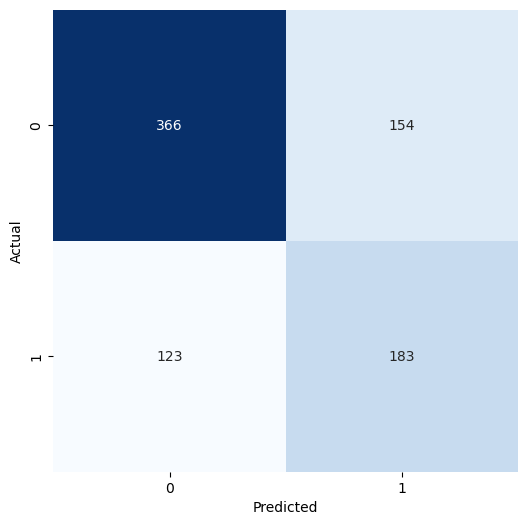


Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.70      0.73       520
           1       0.54      0.60      0.57       306

    accuracy                           0.66       826
   macro avg       0.65      0.65      0.65       826
weighted avg       0.67      0.66      0.67       826



In [35]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
# Compute confusion matrix
cm = confusion_matrix(test_label, predictions_labels)

# Plot confusion matrix
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

print("\nClassification Report:")
print(classification_report(test_label, predictions_labels))

Second Approach

In [19]:
data.head()

,id,img,label,text,clean_text
0,42953,img/42953.png,0,its their character not their color that matters,character color matters
1,23058,img/23058.png,0,don't be afraid to love again everyone is not ...,afraid love everyone like ex
2,13894,img/13894.png,0,putting bows on your pet,putting bows pet
3,37408,img/37408.png,0,i love everything and everybody! except for sq...,love everything everybody except squirrels hat...
4,82403,img/82403.png,0,"everybody loves chocolate chip cookies, even h...",everybody loves chocolate chip cookies even hi...


In [39]:
import json
import re
import string
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from PIL import Image
import tensorflow_hub as hub
from tqdm import tqdm
import os

# Define parameters
max_sequence_length = 100  # Adjust as needed
image_size = (224, 224)

train_text_data = []
train_image_data_paths = []
train_labels = []

test_text_data = []
test_image_data_paths = []
test_labels = []
for img, text, label in zip(X_train["img"].values, X_train['clean_text'].values, X_train['label'].values):
    if os.path.exists(DATA_PATH+f'''/{img}'''):
        train_text_data.append(text)
        train_image_data_paths.append(img)
        train_labels.append(label)

for img, text, label in zip(X_test["img"].values, X_test['clean_text'].values, X_test['label'].values):
    if os.path.exists(DATA_PATH+f'''/{img}'''):
        test_text_data.append(text)
        test_image_data_paths.append(img)
        test_labels.append(label)

tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_text_data)

    
train_sequences = tokenizer.texts_to_sequences(train_text_data)
train_padded_sequences = pad_sequences(train_sequences, maxlen=max_sequence_length)

test_sequences = tokenizer.texts_to_sequences(test_text_data)
test_padded_sequences = pad_sequences(test_sequences, maxlen=max_sequence_length)
  
# Function to preprocess image data
def preprocess_image(image_path, image_size):

    image = Image.open(DATA_PATH+f'''/{image_path}''')
    image = image.resize(image_size)  # Adjust the size as needed
        # Convert the image to RGB
    image = image.convert('RGB')
    image = np.array(image)  # Normalize image data
    return image




# Preprocess image data
train_image_data = [preprocess_image(path, image_size) for path in tqdm(train_image_data_paths)]
test_image_data = [preprocess_image(path, image_size) for path in tqdm(test_image_data_paths)]
word_index = tokenizer.word_index
# Convert text and image data to TensorFlow tensors
train_text_data = tf.constant(train_padded_sequences)
test_text_data = tf.constant(test_padded_sequences)
train_image_data = tf.constant(train_image_data)
test_image_data = tf.constant(test_image_data)




  0%|          | 0/3452 [00:00<?, ?it/s]

  0%|          | 6/3452 [00:00<01:01, 55.74it/s]

  0%|          | 13/3452 [00:00<00:57, 59.54it/s]

  1%|          | 20/3452 [00:00<00:55, 62.19it/s]

  1%|          | 27/3452 [00:00<00:55, 61.43it/s]

  1%|          | 34/3452 [00:00<00:57, 59.28it/s]

  1%|          | 41/3452 [00:00<00:56, 60.71it/s]

  1%|▏         | 48/3452 [00:00<00:56, 60.44it/s]

  2%|▏         | 55/3452 [00:00<00:55, 61.52it/s]

  2%|▏         | 62/3452 [00:01<00:56, 59.88it/s]

  2%|▏         | 69/3452 [00:01<00:59, 56.47it/s]

  2%|▏         | 75/3452 [00:01<01:00, 55.40it/s]

  2%|▏         | 82/3452 [00:01<00:58, 57.94it/s]

  3%|▎         | 90/3452 [00:01<00:54, 61.34it/s]

  3%|▎         | 97/3452 [00:01<00:58, 57.76it/s]

  3%|▎         | 104/3452 [00:01<00:56, 59.53it/s]

  3%|▎         | 111/3452 [00:01<00:56, 58.67it/s]

  3%|▎         | 118/3452 [00:01<00:54, 60.78it/s]

  4%|▎         | 125/3452 [00:02<00:54, 61.20it/s]

  4%|▍         | 132/3452 [00:02<00

In [40]:

# Now, you can use 'text_data' and 'image_data' as inputs to your multimodal model.

# Sample code for creating a multimodal model using TensorFlow/Keras
text_input = tf.keras.layers.Input(shape=(max_sequence_length,))
image_input = tf.keras.layers.Input(shape=(*image_size, 3))


# Define text embedding layer (you can replace this with a more complex text model)
text_embedding = tf.keras.layers.Embedding(input_dim=len(word_index) + 1, output_dim=128)(text_input)
text_embedding = tf.keras.layers.Flatten()(text_embedding)

# Define image embedding layer using a larger model like InceptionV3
image_embedding = hub.KerasLayer("https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4", input_shape=(299, 299, 3))(image_input)

In [41]:

# Concatenate text and image embeddings
combined = tf.keras.layers.concatenate([text_embedding, image_embedding])


# Add more layers as needed for your specific task
output = tf.keras.layers.Dense(1, activation='sigmoid')(combined)

model_2 = tf.keras.models.Model(inputs=[text_input, image_input], outputs=output)

# Compile the model
model_2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [44]:
 
model_2.fit([train_text_data, train_image_data], np.asarray(train_labels), epochs=10, validation_data=([test_text_data,test_image_data],np.asarray(test_labels)))


Epoch 1/10
108/108 [==============================] - 16s 149ms/step - loss: 1.5855 - accuracy: 0.5747 - val_loss: 1.9176 - val_accuracy: 0.6271
Epoch 2/10
108/108 [==============================] - 13s 114ms/step - loss: 1.1610 - accuracy: 0.6379 - val_loss: 1.1371 - val_accuracy: 0.6320
Epoch 3/10
108/108 [==============================] - 10s 96ms/step - loss: 0.7288 - accuracy: 0.7483 - val_loss: 1.6190 - val_accuracy: 0.5036
Epoch 4/10
108/108 [==============================] - 10s 96ms/step - loss: 0.4520 - accuracy: 0.8314 - val_loss: 1.1512 - val_accuracy: 0.6441
Epoch 5/10
108/108 [==============================] - 11s 99ms/step - loss: 0.2754 - accuracy: 0.8940 - val_loss: 1.3213 - val_accuracy: 0.5557
Epoch 6/10
108/108 [==============================] - 9s 85ms/step - loss: 0.3774 - accuracy: 0.8711 - val_loss: 1.5617 - val_accuracy: 0.5884
Epoch 7/10
108/108 [==============================] - 9s 88ms/step - loss: 0.2176 - accuracy: 0.9192 - val_loss: 1.3250 - val_accuracy:

In [45]:
from sklearn.metrics import roc_auc_score
predictions = model_2.predict([test_text_data, test_image_data])
predictions_labels = []
for i in predictions:
    if i >= 0.5:
        predictions_labels.append(1)
    else:
        predictions_labels.append(0)

# Compute the AUROC
auroc = roc_auc_score(test_labels, predictions_labels)

print(f'AUROC: {auroc}')

26/26 [==============================] - 2s 69ms/step
AUROC: 0.5921191553544495


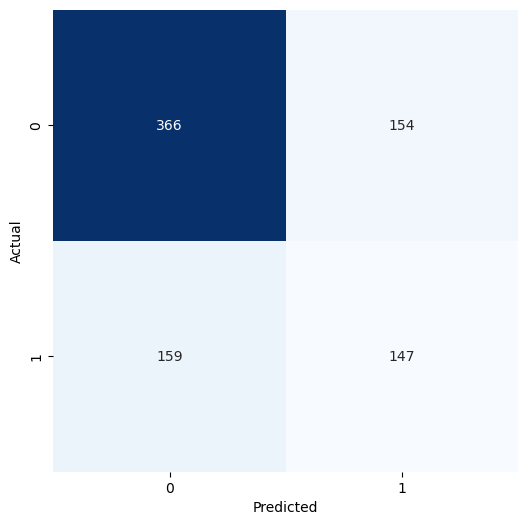


Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.70      0.70       520
           1       0.49      0.48      0.48       306

    accuracy                           0.62       826
   macro avg       0.59      0.59      0.59       826
weighted avg       0.62      0.62      0.62       826



In [46]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
# Compute confusion matrix
cm = confusion_matrix(test_labels, predictions_labels)

# Plot confusion matrix
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

print("\nClassification Report:")
print(classification_report(test_labels, predictions_labels))

In [47]:
# lets try with another parameters

# Now, you can use 'text_data' and 'image_data' as inputs to your multimodal model.

# Sample code for creating a multimodal model using TensorFlow/Keras
text_input = tf.keras.layers.Input(shape=(max_sequence_length,))
image_input = tf.keras.layers.Input(shape=(*image_size, 3))


# Define text embedding layer (you can replace this with a more complex text model)
text_embedding = tf.keras.layers.Embedding(input_dim=len(word_index) + 1, output_dim=128)(text_input)
text_embedding = tf.keras.layers.Flatten()(text_embedding)

# Define image embedding layer using a larger model like InceptionV3
image_embedding = hub.KerasLayer("https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4", input_shape=(299, 299, 3))(image_input)

 27%|██▋       | 946/3452 [16:10<42:51,  1.03s/it]


In [48]:

# Concatenate text and image embeddings
combined = tf.keras.layers.concatenate([text_embedding, image_embedding])


# Add more layers as needed for your specific task
output = tf.keras.layers.Dense(1, activation='sigmoid')(combined)

model_3 = tf.keras.models.Model(inputs=[text_input, image_input], outputs=output)

# Compile the model
model_3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [50]:
 
model_3.fit([train_text_data, train_image_data], np.asarray(train_labels), epochs=10, validation_data=([test_text_data,test_image_data],np.asarray(test_labels)))


Epoch 1/10
108/108 [==============================] - 28s 210ms/step - loss: 7.4609 - accuracy: 0.5623 - val_loss: 3.0742 - val_accuracy: 0.5109
Epoch 2/10
108/108 [==============================] - 15s 133ms/step - loss: 3.1459 - accuracy: 0.5742 - val_loss: 2.9760 - val_accuracy: 0.4867
Epoch 3/10
108/108 [==============================] - 12s 114ms/step - loss: 4.6574 - accuracy: 0.5823 - val_loss: 3.1241 - val_accuracy: 0.6211
Epoch 4/10
108/108 [==============================] - 12s 112ms/step - loss: 2.2847 - accuracy: 0.6544 - val_loss: 4.7054 - val_accuracy: 0.6320
Epoch 5/10
108/108 [==============================] - 12s 107ms/step - loss: 1.7524 - accuracy: 0.7222 - val_loss: 2.3416 - val_accuracy: 0.5569
Epoch 6/10
108/108 [==============================] - 12s 108ms/step - loss: 1.2928 - accuracy: 0.7764 - val_loss: 3.4099 - val_accuracy: 0.4952
Epoch 7/10
108/108 [==============================] - 12s 112ms/step - loss: 1.4686 - accuracy: 0.7729 - val_loss: 2.0566 - val_ac

In [51]:
from sklearn.metrics import roc_auc_score
predictions = model_3.predict([test_text_data, test_image_data])
predictions_labels = []
for i in predictions:
    if i >= 0.5:
        predictions_labels.append(1)
    else:
        predictions_labels.append(0)

# Compute the AUROC
auroc = roc_auc_score(test_labels, predictions_labels)

print(f'AUROC: {auroc}')

26/26 [==============================] - 3s 84ms/step
AUROC: 0.6122171945701358


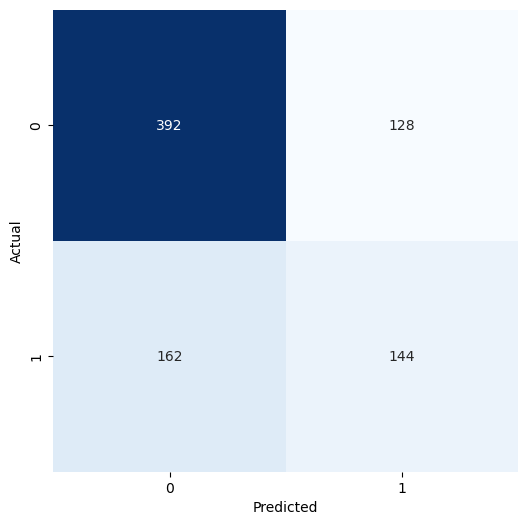


Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.75      0.73       520
           1       0.53      0.47      0.50       306

    accuracy                           0.65       826
   macro avg       0.62      0.61      0.61       826
weighted avg       0.64      0.65      0.64       826



In [52]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
# Compute confusion matrix
cm = confusion_matrix(test_labels, predictions_labels)

# Plot confusion matrix
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

print("\nClassification Report:")
print(classification_report(test_labels, predictions_labels))

Third approach

In [53]:
# Import the necessary libraries
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import Model
import numpy as np

# Load the ResNet model without the top classification layer
base_model = ResNet50(weights='imagenet', include_top=False)

# # Define the layer from which you want to extract features
# feature_extractor = Model(inputs=base_model.input, outputs=base_model.get_layer('desired_layer_name').output)

# # Load and preprocess your image
# img_path = 'your_image.jpg'
# img = image.load_img(img_path, target_size=(224, 224))
# x = image.img_to_array(img)
# x = np.expand_dims(x, axis=0)
# x = preprocess_input(x)

# # Extract features from the image
# features = feature_extractor.predict(x)

# Now, 'features' contains the extracted features from your image using ResNet


94765736/94765736 [==============================] - 1s 0us/step


In [54]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, None, None,   0           ['input_8[0][0]']                
                                3)                                                                
                                                                                                  
 conv1_conv (Conv2D)            (None, None, None,   9472        ['conv1_pad[0][0]']              
                                64)                                                        

In [56]:
last_layer_output = base_model.layers[-1].output

In [57]:
reshaped_output = tf.keras.layers.Reshape(target_shape=(100352,))(last_layer_output)

In [59]:
# Define the layer from which you want to extract features
feature_extractor = Model(inputs=base_model.input, outputs=reshaped_output)
train_preprocessed_resnet_50 = []
test_preprocessed_resnet_50 = []
for i in tqdm(train_image_data_paths):
    img = image.load_img(DATA_PATH+f'''/{i}''', target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)

    x = preprocess_input(x)

    train_preprocessed_resnet_50.append(x)

for i in tqdm(test_image_data_paths):
    img = image.load_img(DATA_PATH+f'''/{i}''', target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)

    x = preprocess_input(x)

    test_preprocessed_resnet_50.append(x)

100%|██████████| 826/826 [00:11<00:00, 70.59it/s]


In [58]:
text_embedding

<KerasTensor: shape=(None, 12800) dtype=float32 (created by layer 'flatten_2')>

In [60]:
feature_extractor.output

<KerasTensor: shape=(None, 100352) dtype=float32 (created by layer 'reshape')>

In [61]:

# Concatenate text and image embeddings
combined = tf.keras.layers.concatenate([text_embedding, feature_extractor.output])


# Add more layers as needed for your specific task
output = tf.keras.layers.Dense(1, activation='sigmoid')(combined)

model_4 = tf.keras.models.Model(inputs=[text_input, base_model.input], outputs=output)

# Compile the model
model_4.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [62]:
train_preprocessed_resnet_50 = np.reshape(np.asarray(train_preprocessed_resnet_50), (len(train_preprocessed_resnet_50), 224, 224, 3))
test_preprocessed_resnet_50 = np.reshape(np.asarray(test_preprocessed_resnet_50), (len(test_preprocessed_resnet_50), 224, 224, 3))

In [63]:
tf.config.experimental_run_functions_eagerly(True)
model_4.fit([train_text_data, train_preprocessed_resnet_50], np.asarray(train_labels), epochs=10,
         validation_data=([test_text_data,test_preprocessed_resnet_50 ], np.asarray(test_labels)))


/opt/conda/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:254: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/10
108/108 [==============================] - 110s 978ms/step - loss: 1.8694 - accuracy: 0.7451 - val_loss: 3720.4268 - val_accuracy: 0.6283
Epoch 2/10
108/108 [==============================] - 102s 948ms/step - loss: 0.9531 - accuracy: 0.8830 - val_loss: 224.4380 - val_accuracy: 0.6283
Epoch 3/10
108/108 [==============================] - 103s 952ms/step - loss: 0.5840 - accuracy: 0.9041 - val_loss: 15.5284 - val_accuracy: 0.5944
Epoch 4/10
108/108 [==============================] - 103s 951ms/step - loss: 0.4170 - accuracy: 0.9177 - val_loss: 67.6055 - val_accuracy: 0.5605
Epoch 5/10
108/108 [==============================] - 103s 951ms/step - loss: 0.5098 - accuracy: 0.9224 - val_loss: 16.1855 - val_accuracy: 0.6598
Epoch 6/10
108/108 [==============================] - 103s 952ms/step - loss: 0.3786 - accuracy: 0.9302 - val_loss: 4.0610 - val_accuracy: 0.6332
Epoch 7/10
108/108 [==============================] - 103s 951ms/step - loss: 0.2350 - accuracy: 0.9360 - val_loss: 

In [64]:
from sklearn.metrics import roc_auc_score
predictions = model_4.predict([test_text_data, test_image_data])
predictions_labels = []
for i in predictions:
    if i >= 0.5:
        predictions_labels.append(1)
    else:
        predictions_labels.append(0)

# Compute the AUROC
auroc = roc_auc_score(test_labels, predictions_labels)

print(f'AUROC: {auroc}')

26/26 [==============================] - 3s 116ms/step
AUROC: 0.5419808949220714


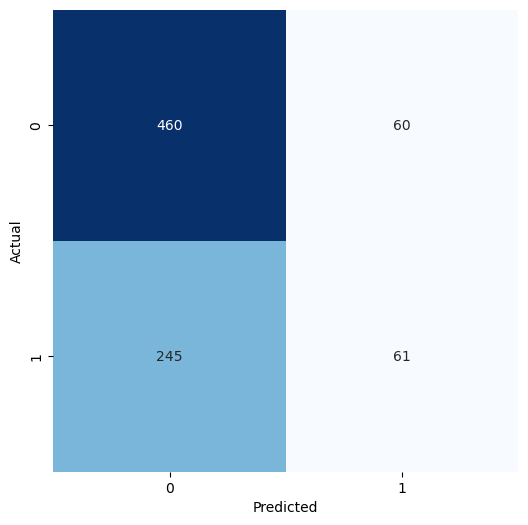


Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.88      0.75       520
           1       0.50      0.20      0.29       306

    accuracy                           0.63       826
   macro avg       0.58      0.54      0.52       826
weighted avg       0.60      0.63      0.58       826



In [65]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
# Compute confusion matrix
cm = confusion_matrix(test_labels, predictions_labels)

# Plot confusion matrix
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

print("\nClassification Report:")
print(classification_report(test_labels, predictions_labels))

In [37]:
from PIL import Image
import requests
from transformers import AutoProcessor, TFCLIPVisionModel

model = TFCLIPVisionModel.from_pretrained("openai/clip-vit-base-patch32")
processor = AutoProcessor.from_pretrained("openai/clip-vit-base-patch32")

url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)

inputs = processor(images=image, return_tensors="tf")

outputs = model(**inputs)
last_hidden_state = outputs.last_hidden_state
pooled_output = outputs.pooler_output  # pooled CLS states

Some layers from the model checkpoint at openai/clip-vit-base-patch32 were not used when initializing TFCLIPVisionModel: ['clip/text_model/embeddings/token_embedding/weight:0', 'clip/text_model/encoder/layers_._8/layer_norm1/gamma:0', 'clip/text_model/encoder/layers_._5/self_attn/k_proj/kernel:0', 'clip/text_model/encoder/layers_._11/self_attn/k_proj/bias:0', 'clip/text_model/encoder/layers_._8/mlp/fc1/kernel:0', 'clip/text_model/encoder/layers_._3/self_attn/k_proj/kernel:0', 'clip/text_model/encoder/layers_._10/self_attn/out_proj/kernel:0', 'clip/text_model/encoder/layers_._1/mlp/fc2/kernel:0', 'clip/text_model/encoder/layers_._9/self_attn/q_proj/kernel:0', 'clip/text_model/encoder/layers_._9/self_attn/v_proj/bias:0', 'clip/text_model/encoder/layers_._4/self_attn/q_proj/kernel:0', 'clip/text_model/encoder/layers_._6/self_attn/out_proj/bias:0', 'clip/text_model/encoder/layers_._4/mlp/fc2/kernel:0', 'clip/text_model/encoder/layers_._5/layer_norm2/gamma:0', 'clip/text_model/encoder/layer

In [38]:
from transformers import AutoTokenizer, TFCLIPTextModel

model = TFCLIPTextModel.from_pretrained("openai/clip-vit-base-patch32")
tokenizer = AutoTokenizer.from_pretrained("openai/clip-vit-base-patch32")

inputs = tokenizer(["a photo of a cat"], padding=True, return_tensors="tf")

outputs = model(**inputs)
last_hidden_state = outputs.last_hidden_state
pooled_output = outputs.pooler_output  # pooled (EOS token) states


Some layers from the model checkpoint at openai/clip-vit-base-patch32 were not used when initializing TFCLIPTextModel: ['clip/vision_model/encoder/layers_._7/mlp/fc2/kernel:0', 'clip/vision_model/encoder/layers_._9/mlp/fc2/bias:0', 'clip/vision_model/encoder/layers_._1/self_attn/k_proj/kernel:0', 'clip/vision_model/encoder/layers_._4/self_attn/q_proj/kernel:0', 'clip/vision_model/encoder/layers_._0/self_attn/q_proj/kernel:0', 'clip/vision_model/encoder/layers_._7/layer_norm2/gamma:0', 'clip/vision_model/encoder/layers_._8/mlp/fc2/bias:0', 'clip/vision_model/encoder/layers_._1/self_attn/out_proj/kernel:0', 'clip/vision_model/encoder/layers_._9/self_attn/v_proj/bias:0', 'clip/vision_model/encoder/layers_._7/self_attn/k_proj/bias:0', 'clip/vision_model/encoder/layers_._4/mlp/fc2/bias:0', 'clip/vision_model/encoder/layers_._10/self_attn/out_proj/kernel:0', 'clip/vision_model/encoder/layers_._7/self_attn/v_proj/bias:0', 'clip/vision_model/encoder/layers_._5/layer_norm1/beta:0', 'clip/vision

In [ ]:
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense, Concatenate
from transformers import TFCLIPVisionModel, TFCLIPTextModel
import tensorflow as tf
text_shape = (128,) 
vision_inputs = Input(shape=(3, 224, 224), name='vision_inputs')
# Assuming your text data is in a variable called text_data
tokenized_text = tokenizer(list(data['text'].values), padding=True, truncation=True, return_tensors="tf")

# Now, text_inputs can be constructed using tokenized_text['input_ids']
text_inputs = Input(shape=(tokenized_text['input_ids'].shape[1],), dtype=tf.int32, name='text_inputs')

# Assume that vision_model and text_model are your pre-trained CLIP vision and text models
vision_model = TFCLIPVisionModel.from_pretrained("openai/clip-vit-base-patch32")
text_model = TFCLIPTextModel.from_pretrained("openai/clip-vit-base-patch32")

# Get the pooled outputs
vision_pooled_output = vision_model(vision_inputs)['pooler_output']
text_pooled_output = text_model(text_inputs)['pooler_output']

# Concatenate the pooled outputs
concatenated = Concatenate()([vision_pooled_output, text_pooled_output])

# Pass the concatenated output to a Dense layer with a single unit and a sigmoid activation function
output = Dense(1, activation='sigmoid')(concatenated)

# Create a Keras model
model = Model(inputs=[vision_inputs, text_inputs], outputs=output)


In [48]:
import pandas as pd

data = pd.read_csv("/kaggle/input/dm-dataset/data mining project/hatefulmemes.csv")
data.head()


,id,img,label,text
0,42953,img/42953.png,0,its their character not their color that matters
1,23058,img/23058.png,0,don't be afraid to love again everyone is not ...
2,13894,img/13894.png,0,putting bows on your pet
3,37408,img/37408.png,0,i love everything and everybody! except for sq...
4,82403,img/82403.png,0,"everybody loves chocolate chip cookies, even h..."


In [54]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 vision_inputs (InputLayer)     [(None, 3, 224, 224  0           []                               
                                )]                                                                
                                                                                                  
 text_inputs (InputLayer)       [(None, 77)]         0           []                               
                                                                                                  
 tfclip_vision_model_8 (TFCLIPV  TFBaseModelOutputWi  87456000   ['vision_inputs[0][0]']          
 isionModel)                    thPooling(last_hidd                                               
                                en_state=(None, 50,                                         

In [58]:
from sklearn.model_selection import train_test_split
X_train, X_testv = train_test_split(data, shuffle=True, random_state=42, test_size=0.2)

In [80]:
from tqdm import tqdm
train_image_data = []
train_text_data = []
train_labels = []

test_image_data = []
test_text_data = []
test_labels = []
c = 1
c1 = 1
for index, row in tqdm(X_train.iterrows(), total=len(X_train)):

    try:
        image_path = f"/kaggle/input/dm-dataset/data mining project/{row['img']}"
        image = Image.open(image_path)
        vision_inputs = processor(images=image, return_tensors="tf")
        text_inputs = tokenizer([row["text"]], padding=True, return_tensors="tf")
        # Get the pooled outputs
        vision_pooled_output = vision_model(vision_inputs)['pooler_output']
        text_pooled_output = text_model(text_inputs)['pooler_output']
        train_image_data.append(vision_pooled_output)
        train_text_data.append(text_pooled_output)
        train_labels.append(row['label'])
    except Exception as e:
        pass


for index, row in tqdm(X_testv.iterrows(), total=len(X_testv)):

    try:
        image_path = f"/kaggle/input/dm-dataset/data mining project/{row['img']}"
        image = Image.open(image_path)
        vision_inputs = processor(images=image, return_tensors="tf")
        text_inputs = tokenizer([row["text"]], padding=True, return_tensors="tf")
        # Get the pooled outputs
        vision_pooled_output = vision_model(vision_inputs)['pooler_output']
        text_pooled_output = text_model(text_inputs)['pooler_output']
        test_image_data.append(vision_pooled_output)
        test_text_data.append(text_pooled_output)
        test_labels.append(row['label'])
    except Exception as e:
        pass

    

100%|██████████| 1700/1700 [05:52<00:00,  4.83it/s]


In [81]:
import numpy as np
train_image_data = np.asarray(train_image_data)
train_text_data = np.asarray(train_text_data)
train_labels = np.asarray(train_labels)

test_image_data = np.asarray(test_image_data)
test_text_data = np.asarray(test_text_data)
test_labels = np.asarray(test_labels)

In [84]:
train_image_data.shape

(3452, 1, 768)

In [85]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Concatenate, Input

# Assume that the size of your image and text embeddings is 512
image_embedding_size = 768
text_embedding_size = 512

# Create input layers
image_input = Input(shape=(image_embedding_size,))
text_input = Input(shape=(text_embedding_size,))

# Concatenate the inputs
concatenated = Concatenate()([image_input, text_input])

# Add a Dense layer with a single unit and a sigmoid activation function
output = Dense(1, activation='sigmoid')(concatenated)

# Create the model
model = Model(inputs=[image_input, text_input], outputs=output)

In [86]:
train_image_data = np.squeeze(train_image_data, axis=1)
train_text_data = np.squeeze(train_text_data, axis=1)
test_image_data = np.squeeze(test_image_data, axis=1)
test_text_data = np.squeeze(test_text_data, axis=1)

In [87]:
import pickle
with open("train_image_data.pkl", "wb") as f:
    pickle.dump(train_image_data, f)
with open("test_image_data.pkl", "wb") as f:
    pickle.dump(test_image_data, f)
with open("train_text_data.pkl", "wb") as f:
    pickle.dump(train_text_data, f)
with open("test_text_data.pkl", "wb") as f:
    pickle.dump(test_text_data, f)
with open("train_labels.pkl", "wb") as f:
    pickle.dump(train_labels, f)
with open("test_labels.pkl", "wb") as f:
    pickle.dump(test_labels, f)

In [88]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [89]:
model.fit([train_image_data,train_text_data], train_labels, epochs=10, validation_data=([test_image_data, test_text_data], test_labels))

Epoch 1/10
108/108 [==============================] - 1s 5ms/step - loss: 0.6485 - accuracy: 0.6622 - val_loss: 0.5873 - val_accuracy: 0.6998
Epoch 2/10
108/108 [==============================] - 0s 3ms/step - loss: 0.5352 - accuracy: 0.7381 - val_loss: 0.5665 - val_accuracy: 0.7179
Epoch 3/10
108/108 [==============================] - 0s 4ms/step - loss: 0.4853 - accuracy: 0.7674 - val_loss: 0.5545 - val_accuracy: 0.7228
Epoch 4/10
108/108 [==============================] - 0s 4ms/step - loss: 0.4568 - accuracy: 0.7914 - val_loss: 0.5401 - val_accuracy: 0.7421
Epoch 5/10
108/108 [==============================] - 0s 4ms/step - loss: 0.4388 - accuracy: 0.7975 - val_loss: 0.5282 - val_accuracy: 0.7349
Epoch 6/10
108/108 [==============================] - 0s 4ms/step - loss: 0.4247 - accuracy: 0.8123 - val_loss: 0.5313 - val_accuracy: 0.7409
Epoch 7/10
108/108 [==============================] - 0s 4ms/step - loss: 0.4093 - accuracy: 0.8218 - val_loss: 0.5315 - val_accuracy: 0.7349
Epoch 

In [90]:
from sklearn.metrics import roc_auc_score
predictions = model.predict([test_image_data, test_text_data])
predictions_labels = []
for i in predictions:
    if i >= 0.5:
        predictions_labels.append(1)
    else:
        predictions_labels.append(0)

# Compute the AUROC
auroc = roc_auc_score(test_labels, predictions_labels)

print(f'AUROC: {auroc}')

26/26 [==============================] - 0s 1ms/step
AUROC: 0.6889391654097536


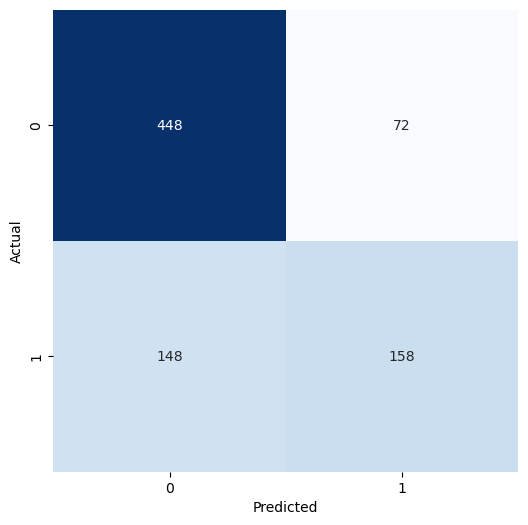


Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.86      0.80       520
           1       0.69      0.52      0.59       306

    accuracy                           0.73       826
   macro avg       0.72      0.69      0.70       826
weighted avg       0.73      0.73      0.72       826



In [91]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
# Compute confusion matrix
cm = confusion_matrix(test_labels, predictions_labels)

# Plot confusion matrix
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

print("\nClassification Report:")
print(classification_report(test_labels, predictions_labels))

In [1]:
import torch
import torch.nn as nn
from transformers import ViTConfig, ViTModel

model_Res = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True)

# Remove the last layer of the model Res
layers_Res = list(model_Res.children())
model_Res = nn.Sequential(*layers_Res[:-1])

# Set the top layers to be not trainable
count = 0


# for child in model_Res.children():
#     count += 1
#     if count < 8:
#         for param in child.parameters():
#             param.requires_grad = False
 

model_trans = ViTModel.from_pretrained('google/vit-base-patch16-224')
# count = 0
# for child in model_trans.children():
#     count += 1
#     if count < 4:
#         for param in child.parameters():
#             param.requires_grad = False

layers_trans = list(model_trans.children()) # Get all the layers from the Transformer model
model_trans_top = nn.Sequential(*layers_trans[:-2]) # Remove the normalization layer and pooler layer
trans_layer_norm = list(model_trans.children())[2] # Get the normalization layer

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

Some weights of the model checkpoint at google/vit-base-patch16-224 were not used when initializing ViTModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing ViTModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.weight', 'vit.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [2]:
import torch.nn.functional as F

class model_final(nn.Module):
    def __init__(self, model_trans_top, trans_layer_norm, model_Res, dp_rate=0.3):
        super().__init__()

        # All the trans model layers
        self.model_trans_top = model_trans_top
        self.trans_layer_norm = trans_layer_norm
        self.trans_flatten = nn.Flatten()
        self.trans_linear = nn.Linear(150528, 2048)
        self.text_linear = nn.Linear(768, 256)

        # All the ResNet model
        self.model_Res = model_Res

        # Merge the result and pass through the layers
        self.dropout = nn.Dropout(dp_rate)
        self.linear1 = nn.Linear(2304, 500)
        self.linear2 = nn.Linear(500, 1)

    def forward(self, trans_b, res_b, text_b):
        # Get intermediate outputs using hidden layer
        result_trans = self.model_trans_top(trans_b)
        patch_state = result_trans.last_hidden_state[:, 1:, :]  # Remove the classification token and get the last hidden state of all patches
        result_trans = self.trans_layer_norm(patch_state)
        result_trans = self.trans_flatten(patch_state)
        result_trans = self.dropout(result_trans)
        result_trans = F.relu(self.trans_linear(result_trans))  # Adding ReLU activation

        result_res = self.model_Res(res_b)
        result_res = torch.reshape(result_res, (result_res.shape[0], result_res.shape[1]))
        text_result = F.relu(self.text_linear(text_b))  # Adding ReLU activation
        text_result = self.dropout(text_result)
        result_merge = torch.cat((result_trans, text_result), 1)
        result_merge = self.dropout(result_merge)
        result_merge = F.relu(self.linear1(result_merge))  # Adding ReLU activation
        result_merge = self.dropout(result_merge)
        result_merge = self.linear2(result_merge)

        # Apply sigmoid activation in the final layer for binary classification
        result_merge = torch.sigmoid(result_merge)

        return result_merge


In [3]:
from tqdm import tqdm
model = model_final(model_trans_top, trans_layer_norm, model_Res, dp_rate = 0.3)

# Set up optimizer and learing rate scheduel
params = [param for param in list(model.parameters()) if param.requires_grad]
optimizer = torch.optim.Adam(params, lr=0.001)

lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='min', 
    factor=0.1, 
    patience=5, 
    verbose=True)

from tqdm import tqdm

def fit(epochs, model, train_dl, valid_dl):
    opt = optimizer
    sched = lr_scheduler
    loss_func = nn.BCEWithLogitsLoss()

    if torch.cuda.is_available():
        device = torch.device("cuda")
        model = nn.DataParallel(model)
        model = model.cuda()
    else:
        device = torch.device("cpu")

    for epoch in range(epochs):
        # Training phase
        model.train()
        total_loss = 0
        correct_predictions = 0
        total_samples = 0

        # Create a new tqdm progress bar for each epoch
        pbar = tqdm(total=len(train_dl), desc=f'Training Epoch {epoch + 1}/{epochs}')

        for i, (x_trans, x_res, text, yb) in enumerate(train_dl):
            x_trans = x_trans.to(device, dtype=torch.float32)
            x_res = x_res.to(device, dtype=torch.float32)
            text = text.to(device)
            yb = yb.to(device, dtype=torch.float32)

            preds = model(x_trans, x_res, text)
            loss = loss_func(preds.squeeze(), yb.squeeze())
            loss.backward()
            opt.step()
            opt.zero_grad()

            total_loss += loss.item()

            # Compute accuracy
            predicted_labels = (preds.squeeze() > 0.5).float()
            correct_predictions += (predicted_labels == yb).sum().item()
            total_samples += yb.size(0)
            # Calculate average loss and accuracy for the current batch
            train_average_loss = total_loss / (i+1)
            train_accuracy = correct_predictions / total_samples

            pbar.set_postfix({'Training Loss': f'{train_average_loss:.4f}', 'Training Accuracy': f'{train_accuracy:.4f}'})
            pbar.update(1)  # Update tqdm progress bar

        pbar.close()  # Close tqdm progress bar for the training epoch

        # Validation phase
        model.eval()
        val_loss = 0
        val_correct_predictions = 0
        val_total_samples = 0

        with torch.no_grad():
            # Create a new tqdm progress bar for validation
            pbar_val = tqdm(total=len(valid_dl), desc=f'Validation Epoch {epoch + 1}/{epochs}')

            for x_trans_val, x_res_val, text_val, yb_val in valid_dl:
                x_trans_val = x_trans_val.to(device, dtype=torch.float32)
                x_res_val = x_res_val.to(device, dtype=torch.float32)
                text_val = text_val.to(device)
                yb_val = yb_val.to(device, dtype=torch.float32)

                preds_val = model(x_trans_val, x_res_val, text_val)
                loss_val = loss_func(preds_val.squeeze(), yb_val.squeeze())

                val_loss += loss_val.item()

                # Compute accuracy for validation
                predicted_labels_val = (preds_val.squeeze() > 0.5).float()
                val_correct_predictions += (predicted_labels_val == yb_val).sum().item()
                val_total_samples += yb_val.size(0)

                pbar_val.update(1)  # Update tqdm progress bar

            pbar_val.close()  # Close tqdm progress bar for validation

        # Calculate average loss and accuracy for both training and validation
        train_average_loss = total_loss / len(train_dl)
        train_accuracy = correct_predictions / total_samples

        val_average_loss = val_loss / len(valid_dl)
        val_accuracy = val_correct_predictions / val_total_samples

        print(f'Training Loss: {train_average_loss:.4f}, Training Accuracy: {train_accuracy:.4f}')
        print(f'Validation Loss: {val_average_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

        # Learning rate scheduler step based on validation loss
        sched.step(val_average_loss)

# Example usage:
# fit(epochs, model, train_dataloader, optimizer, lr_scheduler)


In [4]:
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os
import numpy as np
from transformers import BertTokenizer, BertModel
import torch

# Load pre-trained BERT model and tokenizer
model_name = 'bert-base-uncased'  # You can change this to the desired BERT variant
tokenizer = BertTokenizer.from_pretrained(model_name)
bert = BertModel.from_pretrained(model_name)
data = pd.read_csv("/kaggle/input/dm-dataset/data mining project/hatefulmemes.csv")
# Filter DataFrame based on existing image files
data['img_exists'] = data['img'].apply(lambda x: os.path.exists(f"/kaggle/input/dm-dataset/data mining project/{x}"))
data = data[data['img_exists']]

import pandas as pd
from sklearn.model_selection import train_test_split

# Assuming df is your DataFrame
# Replace 'target_column' with the actual name of your target column
target_column = 'label'
features_columns = ['img', 'text']

# Split the DataFrame into features and target
X = data[features_columns]
y = data[target_column]

# Split the data into training and validation sets
# Adjust the test_size and random_state as needed
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# Optionally, create new DataFrames for training and validation
train_df = pd.concat([X_train, y_train], axis=1)
valid_df = pd.concat([X_valid, y_valid], axis=1)

# Display the shapes of the resulting DataFrames
print("Training Data Shape:", train_df.shape)
print("Validation Data Shape:", valid_df.shape)


class CustomDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.data = self.data.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text = self.data.loc[idx, 'text']
        img_path = self.data.loc[idx, 'img']
        label = int(self.data.loc[idx, 'label'])

    
        img = Image.open(f"/kaggle/input/dm-dataset/data mining project/{img_path}").convert('RGB')
      
        
        label = np.array(label)
        if self.transform:
            img_tr = self.transform(img)
        img = img.resize((224,224))
        img = np.array(img)
        img = np.transpose(img, (2, 0, 1))
        
        tokens = tokenizer(text, return_tensors='pt')

        # Forward pass through BERT model
        with torch.no_grad():
            outputs = bert(**tokens)

        # Extract embeddings from the last layer
        text_embeddings = outputs.last_hidden_state.mean(dim=1)
#         text_embeddings = text_embeddings.squeeze()
        

        return img,img_tr,text_embeddings.squeeze(),label

# Example usage:
# Define the transformations for image preprocessing
image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Create an instance of the CustomDataset
train_dataset = CustomDataset(data=train_df, transform=image_transform)
test_dataset = CustomDataset(data=valid_df, transform=image_transform)



# Assuming you have a DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=1)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True, num_workers=1)

# Train the model using the fit function
# (You need to define your model before using the fit function)
# fit(epochs, your_model, train_dataloader)


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Training Data Shape: (3422, 3)
Validation Data Shape: (856, 3)


In [5]:
epochs = 10
fit(epochs, model, train_dataloader, test_dataloader)

Validation Epoch 1/10: 100%|██████████| 27/27 [02:07<00:00,  4.72s/it]


Training Loss: 0.6953, Training Accuracy: 0.6394
Validation Loss: 0.6931, Validation Accuracy: 0.6320


Validation Epoch 2/10: 100%|██████████| 27/27 [02:01<00:00,  4.51s/it]


Training Loss: 0.6931, Training Accuracy: 0.6414
Validation Loss: 0.6931, Validation Accuracy: 0.6320


Validation Epoch 3/10: 100%|██████████| 27/27 [02:00<00:00,  4.48s/it]


Training Loss: 0.6931, Training Accuracy: 0.6414
Validation Loss: 0.6931, Validation Accuracy: 0.6320


Validation Epoch 4/10: 100%|██████████| 27/27 [02:00<00:00,  4.46s/it]


Training Loss: 0.6931, Training Accuracy: 0.6414
Validation Loss: 0.6931, Validation Accuracy: 0.6320


Validation Epoch 5/10: 100%|██████████| 27/27 [02:02<00:00,  4.55s/it]


Training Loss: 0.6931, Training Accuracy: 0.6414
Validation Loss: 0.6931, Validation Accuracy: 0.6320


Validation Epoch 6/10: 100%|██████████| 27/27 [02:01<00:00,  4.52s/it]


Training Loss: 0.6931, Training Accuracy: 0.6414
Validation Loss: 0.6931, Validation Accuracy: 0.6320


Validation Epoch 7/10: 100%|██████████| 27/27 [02:02<00:00,  4.54s/it]


Training Loss: 0.6931, Training Accuracy: 0.6414
Validation Loss: 0.6931, Validation Accuracy: 0.6320
Epoch 00007: reducing learning rate of group 0 to 1.0000e-04.


Validation Epoch 8/10: 100%|██████████| 27/27 [02:03<00:00,  4.56s/it]


Training Loss: 0.6931, Training Accuracy: 0.6414
Validation Loss: 0.6931, Validation Accuracy: 0.6320


Validation Epoch 9/10: 100%|██████████| 27/27 [02:01<00:00,  4.49s/it]


Training Loss: 0.6931, Training Accuracy: 0.6414
Validation Loss: 0.6931, Validation Accuracy: 0.6320


Validation Epoch 10/10: 100%|██████████| 27/27 [01:57<00:00,  4.35s/it]

Training Loss: 0.6931, Training Accuracy: 0.6414
Validation Loss: 0.6931, Validation Accuracy: 0.6320


In [6]:
from sklearn.metrics import roc_auc_score
predictions = model.predict([test_image_data, test_text_data])
predictions_labels = []
for i in predictions:
    if i >= 0.5:
        predictions_labels.append(1)
    else:
        predictions_labels.append(0)

# Compute the AUROC
auroc = roc_auc_score(test_labels, predictions_labels)

print(f'AUROC: {auroc}')

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:2                                                                                    │
│                                                                                                  │
│    1 from sklearn.metrics import roc_auc_score                                                   │
│ ❱  2 predictions = model.predict([test_image_data, test_text_data])                              │
│    3 predictions_labels = []                                                                     │
│    4 for i in predictions:                                                                       │
│    5 │   if i >= 0.5:                                                                            │
│                                                                                                  │
│ /opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1614 in __getattr__           │
│                                                                                                  │
│   1611 │   │   │   modules = self.__dict__['_modules']                                           │
│   1612 │   │   │   if name in modules:                                                           │
│   1613 │   │   │   │   return modules[name]                                                      │
│ ❱ 1614 │   │   raise AttributeError("'{}' object has no attribute '{}'".format(                  │
│   1615 │   │   │   type(self).__name__, name))                                                   │
│   1616 │                                                                                         │
│   1617 │   def __setattr__(self, name: str, value: Union[Tensor, 'Module']) -> None:             │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
AttributeError: 'model_final' object has no attribute 'predict'

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
# Compute confusion matrix
cm = confusion_matrix(test_labels, predictions_labels)

# Plot confusion matrix
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

print("\nClassification Report:")
print(classification_report(test_labels, predictions_labels))